<a href="https://colab.research.google.com/github/Farmhouse121/Financial-Data-Science-in-Python/blob/main/Alphas/Market_Return_by_Dates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
from my_library import *

## Get the Data

In [27]:
data,ticker_name=download(ticker:='SPY',end='2019-12-31',auto_adjust=True).xs(ticker,axis=1,level=1),'S&P 500 Index ETF'
data['Return']=data['Close'].pct_change()*hundred
data.columns.name=ticker_name
data.dropna(inplace=True)
data.index=list(map(lambda x:pd.Period(x,'D'),data.index))
data['Weekday']=list(map(lambda x:x.strftime("%A"),data.index))
data['Monthday']=data.index.day
data['DaysInMonth']=list(map(lambda x:pd.Period(x,'M').daysinmonth,data.index))
data['Month']=list(map(lambda x:x.strftime("%B"),data.index))
display(data)

[*********************100%***********************]  1 of 1 completed


S&P 500 Index ETF,Close,High,Low,Open,Volume,Return,Weekday,Monthday,DaysInMonth,Month
1993-02-01,24.626429,24.626429,24.469905,24.469905,480500,0.711192,Monday,1,28,February
1993-02-02,24.678604,24.695996,24.556863,24.609038,201300,0.211868,Tuesday,2,28,February
1993-02-03,24.939486,24.956877,24.696004,24.713395,529400,1.057116,Wednesday,3,28,February
1993-02-04,25.043825,25.096000,24.748169,25.026434,531500,0.418371,Thursday,4,28,February
1993-02-05,25.026438,25.078612,24.887305,25.026438,492100,-0.069428,Friday,5,28,February
...,...,...,...,...,...,...,...,...,...,...
2019-12-23,296.917755,297.315216,296.769857,297.259758,52990000,0.152781,Monday,23,31,December
2019-12-24,296.926971,297.195011,296.621922,297.148805,20270000,0.003104,Tuesday,24,31,December
2019-12-26,298.507568,298.516821,297.305933,297.315157,30911200,0.532318,Thursday,26,31,December
2019-12-27,298.433594,299.302479,297.897487,299.247021,42528800,-0.024781,Friday,27,31,December


15:25:02 Wrote plot to Daily Returns of S&P 500 Index ETF.png.


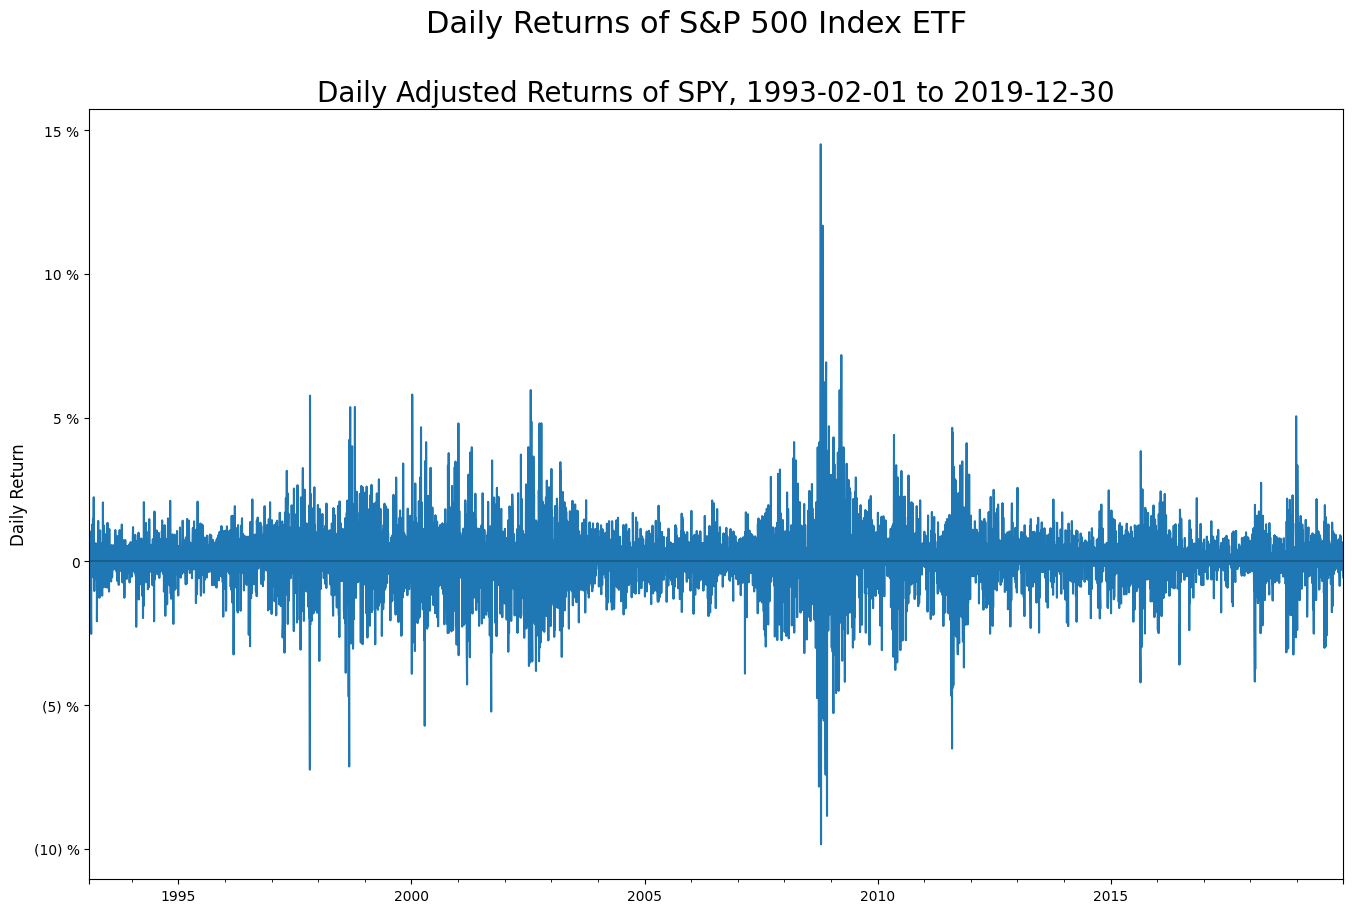

In [28]:
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
data['Return'].plot(ax=plot)
plot.set_ylabel("Daily Return",fontsize=12)
plot.yaxis.set_major_formatter(PercentLabels(0))
figure.suptitle(title:="Daily Returns of {}".format(ticker_name),fontsize=22)
plot.set_title(subtitle:="Daily Adjusted Returns of {}, {} to {}".format(ticker,data.index[0],data.index[-1]),fontsize=20)
figure.savefig(filename:=title+'.png',dpi=300,bbox_inches='tight')
plot.axhline(color='black',alpha=0.2)
nprint("Wrote plot to {}.".format(filename))

## Analyse Returns by Day of the Week
### First Just a Simple Grouped Mean

15:53:31 t Test for a Zero Mean


S&P 500 Index ETF,Mean,Std.Dev.,Count,Std.Err.,t Statistic,p Value
Day of Week,,,,,,
Monday,0.040137,1.264921,1277,0.035397,1.133908,0.257046
Tuesday,0.071448,1.159077,1389,0.031100,2.297352,0.021747
Wednesday,0.051835,1.095636,1390,0.029387,1.763876,0.077973
Thursday,0.023567,1.126049,1364,0.030489,0.772960,0.439680
Friday,0.028856,1.064547,1358,0.028888,0.998891,0.318026


15:53:33 Wrote plot to Average Returns of S&P 500 Index ETF by Day of the Week.png.


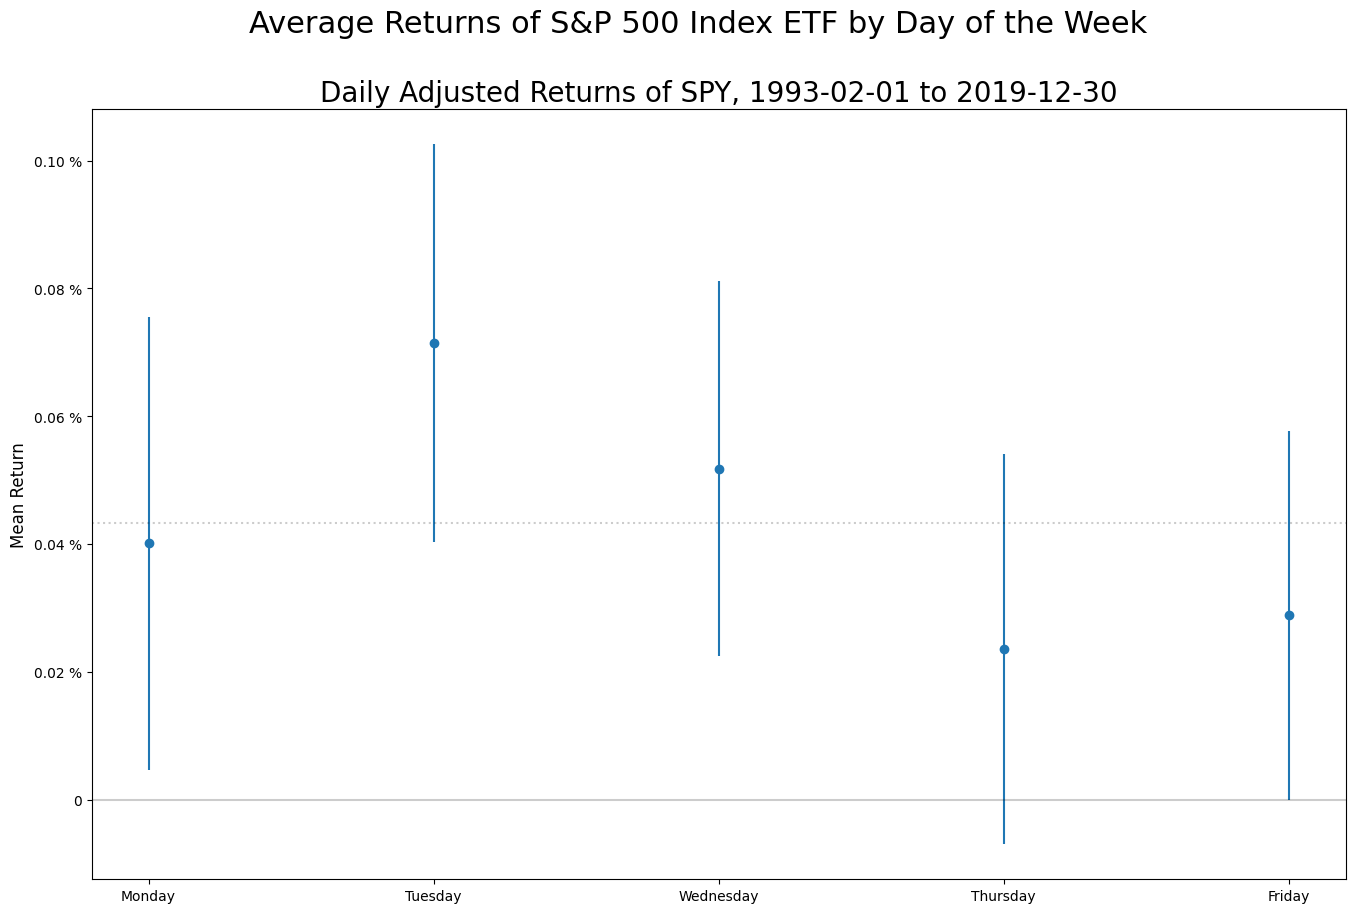

In [40]:
from scipy.stats import t as studentt

nprint("t Test for a Zero Mean")
results=(grouped:=data[['Return','Weekday']].groupby("Weekday")).mean().rename(columns={'Return':'Mean'})
results['Std.Dev.']=grouped.std()
results['Count']=grouped.count()
results['Std.Err.']=results['Std.Dev.']/np.sqrt(results['Count'])
results['t Statistic']=results['Mean']/results['Std.Err.']
results['p Value']=studentt.sf(np.abs(results['t Statistic']),results['Count']-1)*2
results.index.name='Day of Week'
results=results.reindex(['Monday','Tuesday','Wednesday','Thursday','Friday'])
display(results)

figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.errorbar(x:=results.index,y:=results['Mean'],ye:=results['Std.Err.'],fmt='o')
plot.axhline(color='black',alpha=0.2)
plot.set_ylabel("Mean Return",fontsize=12)
plot.yaxis.set_major_formatter(PercentLabels(2))
plot.axhline(data['Return'].mean(),color='black',alpha=0.2,linestyle=':')
figure.suptitle(title:="Average Returns of {} by {}".format(ticker_name,group_name:="Day of the Week"),fontsize=22)
plot.set_title(subtitle:="Daily Adjusted Returns of {}, {} to {}".format(ticker,data.index[0],data.index[-1]),fontsize=20)
figure.savefig(filename:=title+'.png',dpi=300,bbox_inches='tight')
nprint("Wrote plot to {}.".format(filename))

### One Way ANOVA Analysis

In [41]:
from statsmodels.formula.api import ols as OLSformula
from statsmodels.stats.anova import anova_lm

nprint("One Way ANOVA Analysis by {}".format(group_name))
anova=anova_lm(OLSformula("Return ~ Weekday",data).fit(),typ=2).rename(columns={'sum_sq':'Sum of Squares','df':'d.o.f.','PR(>F)':'p Value','F':'F Statistic'})
anova['Significance']=anova['p Value'].apply(lambda x:'***' if x<=0.001 else '**' if x<=0.01 else '*' if x<0.05 else '')
anova.index=['Between Groups','Within Groups']
anova.index.name='Variation'
display(anova.replace(np.nan,""))

15:53:33 One Way ANOVA Analysis by Day of the Week


,Sum of Squares,d.o.f.,F Statistic,p Value,Significance
Variation,,,,,
Between Groups,2.028972,4.0,0.388645,0.816922,
Within Groups,8839.831860,6773.0,,,


### Now do an OLS with Indicator Variables
This will deliver *exactly* the same results as the grouped means, but with some other statistics for "free."

In [42]:
from statsmodels.regression.linear_model import OLS

nprint("Baseline OLS regression with indicator variables. This should produce *exactly* the same results as the conditional means above.")
display(design:=pd.get_dummies(data['Weekday'],columns=['Weekday'],dtype=float)[results.index].merge(data['Return'],left_index=True,right_index=True))
fit=ols_fit=OLS(design['Return'],design.drop('Return',axis=1)).fit()
nprint(fit.summary())

15:53:33 Baseline OLS regression with indicator variables. This should produce *exactly* the same results as the conditional means above.


,Monday,Tuesday,Wednesday,Thursday,Friday,Return
1993-02-01,1.0,0.0,0.0,0.0,0.0,0.711192
1993-02-02,0.0,1.0,0.0,0.0,0.0,0.211868
1993-02-03,0.0,0.0,1.0,0.0,0.0,1.057116
1993-02-04,0.0,0.0,0.0,1.0,0.0,0.418371
1993-02-05,0.0,0.0,0.0,0.0,1.0,-0.069428
...,...,...,...,...,...,...
2019-12-23,1.0,0.0,0.0,0.0,0.0,0.152781
2019-12-24,0.0,1.0,0.0,0.0,0.0,0.003104
2019-12-26,0.0,0.0,0.0,1.0,0.0,0.532318
2019-12-27,0.0,0.0,0.0,0.0,1.0,-0.024781


15:53:33                             OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.3886
Date:                Tue, 22 Apr 2025   Prob (F-statistic):              0.817
Time:                        15:53:33   Log-Likelihood:                -10518.
No. Observations:                6778   AIC:                         2.105e+04
Df Residuals:                    6773   BIC:                         2.108e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Monday         0.0401      0.032      1.255

### Now fit a GJR-GARCH(1,1,1) Model with the Same Dummies and Non-Normal Innovations
This is a _way more accurate_ distributional model that the Normal model assumed by OLS. It will weight high-volatility days appropriately.

In [43]:
from scipy.stats import norm

nprint("Fitting GJR-GARCH(1,1,1) Model with GED Innovations")
model=ARX(design["Return"],design.drop('Return',axis=1),constant=False,lags=0)
model.volatility=GARCH2(1,1,1)
model.distribution=GeneralizedError2()
fit=gjr_fit=model.fit(update_freq=0)
nprint(gjr_fit.summary())
data['Volatility']=gjr_fit.conditional_volatility

results=pd.DataFrame({'Estimate':fit.params,'Std.Err.':fit.std_err,'Null Value':[zero]*(len(fit.params)-5)+[np.nan,zero,zero,zero]+[two]})
results['t Score']=(results['Estimate']-results['Null Value'])/results['Std.Err.']
results['p Value']=list(map(lambda x:min(norm.cdf(x),norm.sf(x))*two,results['t Score']))
results['Significance']=results['p Value'].apply(lambda x:'***' if x<=0.001 else '**' if x<=0.01 else '*' if x<0.05 else '')
display(results.replace(np.nan,""))

15:53:33 Fitting GJR-GARCH(1,1,1) Model with GED Innovations
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8763.598186857007
            Iterations: 19
            Function evaluations: 241
            Gradient evaluations: 19
15:53:34                               AR-X - GJR-GARCH Model Results                              
Dep. Variable:                             Return   R-squared:                      -0.000
Mean Model:                                  AR-X   Adj. R-squared:                 -0.001
Vol Model:                              GJR-GARCH   Log-Likelihood:               -8763.60
Distribution:      Generalized Error Distribution   AIC:                           17547.2
Method:                        Maximum Likelihood   BIC:                           17615.4
                                                    No. Observations:                 6778
Date:                            Tue, Apr 22 2025   Df Residuals:                  

,Estimate,Std.Err.,Null Value,t Score,p Value,Significance
Monday,0.053274,0.019023,0.0,2.800485,0.005103,**
Tuesday,0.035983,0.021162,0.0,1.700371,0.089061,
Wednesday,0.075195,0.018069,0.0,4.161567,0.000032,***
Thursday,0.042088,0.019500,0.0,2.158425,0.030895,*
Friday,0.071240,0.020474,0.0,3.479523,0.000502,***
omega,0.017797,0.003186,,,,
alpha[1],-0.001303,0.006676,0.0,-0.195135,0.845288,
gamma[1],0.196249,0.023180,0.0,8.466443,0.0,***
beta[1],0.886569,0.012111,0.0,73.202511,0.0,***
nu,1.354821,0.037185,2.0,-17.350586,0.0,***


### Repeat the Simple Plot by Day of Week

15:53:35 Wrote plot to Estimated Mean Returns of S&P 500 Index ETF by Day of the Week.png.


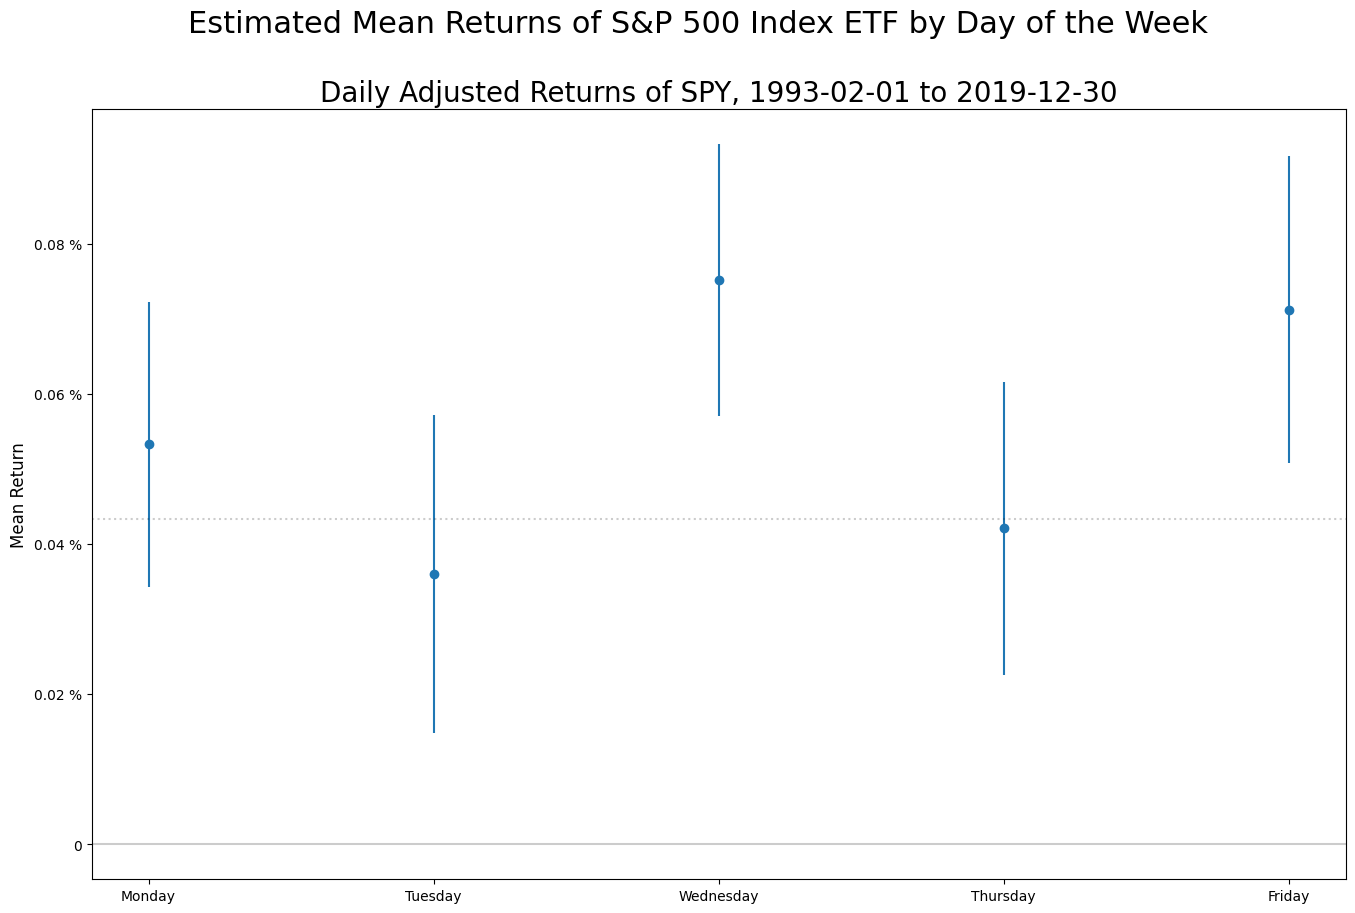

In [44]:
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.errorbar(x,results.loc[x,'Estimate'],results.loc[x,'Std.Err.'],fmt='o')
plot.axhline(color='black',alpha=0.2)
plot.set_ylabel("Mean Return",fontsize=12)
plot.yaxis.set_major_formatter(PercentLabels(2))
plot.axhline(data['Return'].mean(),color='black',alpha=0.2,linestyle=':')
figure.suptitle(title:="Estimated Mean Returns of {} by {}".format(ticker_name,group_name),fontsize=22)
plot.set_title(subtitle:="Daily Adjusted Returns of {}, {} to {}".format(ticker,data.index[0],data.index[-1]),fontsize=20)
figure.savefig(filename:=title+'.png',dpi=300,bbox_inches='tight')
nprint("Wrote plot to {}.".format(filename))

15:53:36 Wrote plot to Effect of Volatilty on Estimated Returns of S&P 500 Index ETF by Day of the Week.png.


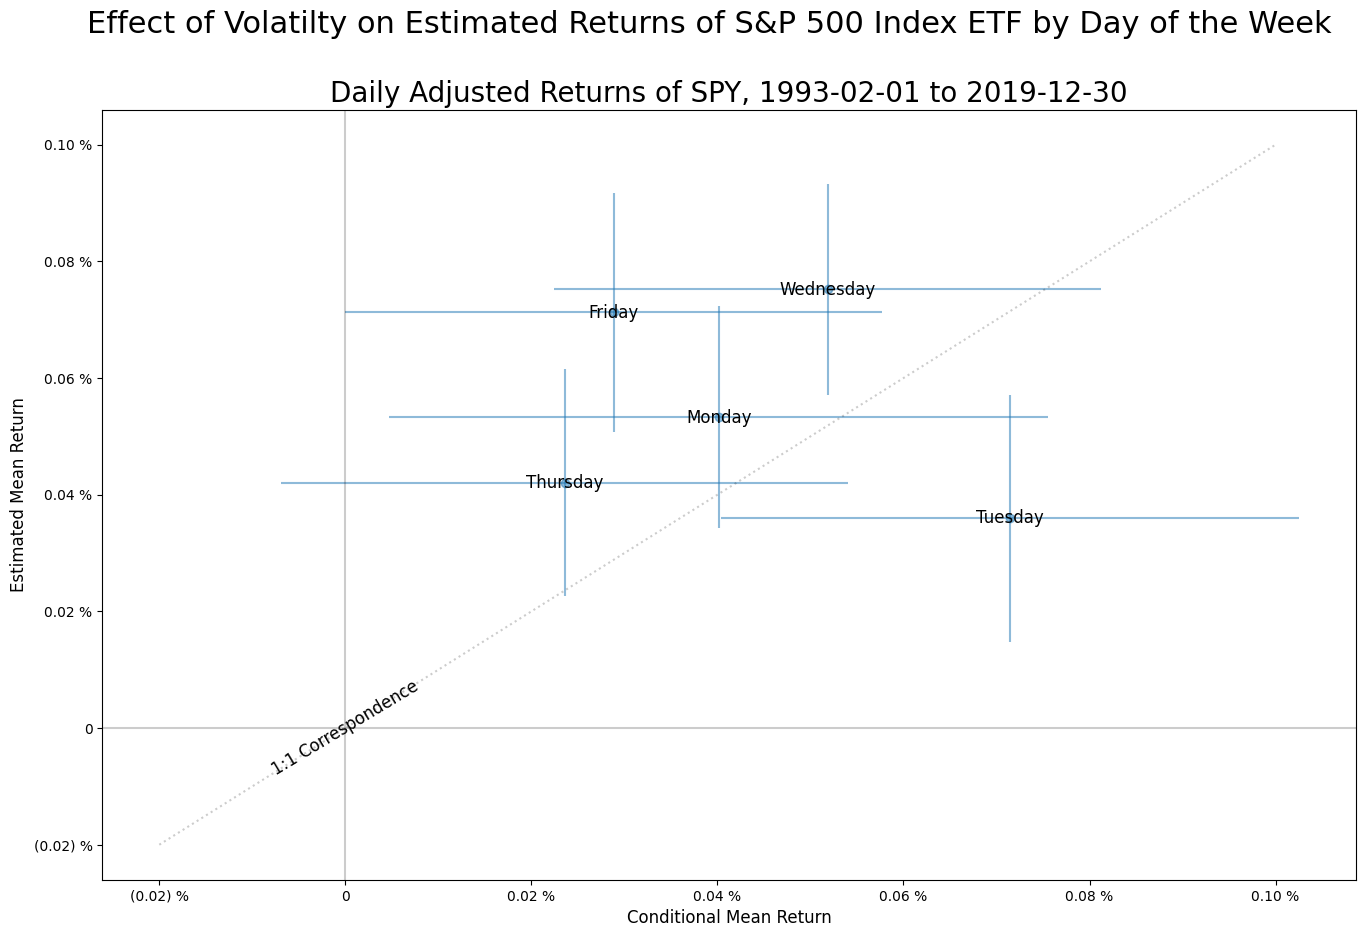

In [45]:
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.errorbar(xx:=y,yy:=results.loc[x,'Estimate'],xerr=ye,yerr=results.loc[x,'Std.Err.'],fmt='o',alpha=0.5)

for day in x:
  plot.text(xx.loc[day],yy.loc[day],day,ha='center',va='center',fontsize=12)

plot.plot(r:=[min([-0.02,xx.min(),yy.min()]),max([0.1,xx.max(),yy.max()])],r,':',color='black',alpha=0.2)
plot.text(zero,zero,'1:1 Correspondence',fontsize=12,ha='center',va='center',rotation=31)
plot.axhline(color='black',alpha=0.2)
plot.axvline(color='black',alpha=0.2)
plot.set_xlabel("Conditional Mean Return",fontsize=12)
plot.set_ylabel("Estimated Mean Return",fontsize=12)
plot.xaxis.set_major_formatter(PercentLabels(2))
plot.yaxis.set_major_formatter(PercentLabels(2))
figure.suptitle(title:="Effect of Volatilty on Estimated Returns of {} by {}".format(ticker_name,group_name:="Day of the Week"),fontsize=22)
plot.set_title(subtitle:="Daily Adjusted Returns of {}, {} to {}".format(ticker,data.index[0],data.index[-1]),fontsize=20)
figure.savefig(filename:=title+'.png',dpi=300,bbox_inches='tight')
nprint("Wrote plot to {}.".format(filename))

## Now Look at Calendar Months
### First Compute the Simple Grouped Means Again

15:53:36 t Test for a Zero Mean


S&P 500 Index ETF,Mean,Std.Dev.,Count,Std.Err.,t Statistic,p Value
Month,,,,,,
January,0.038049,1.121077,531,0.048651,0.782092,0.434510
February,0.015454,1.022404,518,0.044922,0.344025,0.730968
March,0.071040,1.149215,591,0.047272,1.502780,0.133431
April,0.094163,1.033271,557,0.043781,2.150775,0.031924
May,0.033057,0.969629,572,0.040542,0.815365,0.415203
June,0.010260,0.950360,577,0.039564,0.259337,0.795468
July,0.043392,1.011232,570,0.042356,1.024469,0.306049
August,-0.012832,1.161858,599,0.047472,-0.270310,0.787015
September,0.003635,1.208789,547,0.051684,0.070326,0.943960


15:53:37 Wrote plot to Average Returns of S&P 500 Index ETF by Month.png.
15:53:37 One Way ANOVA Analysis by Month


,Sum of Squares,d.o.f.,F Statistic,p Value,Significance
Variation,,,,,
Between Groups,2.028972,4.0,0.388645,0.816922,
Within Groups,8839.831860,6773.0,,,


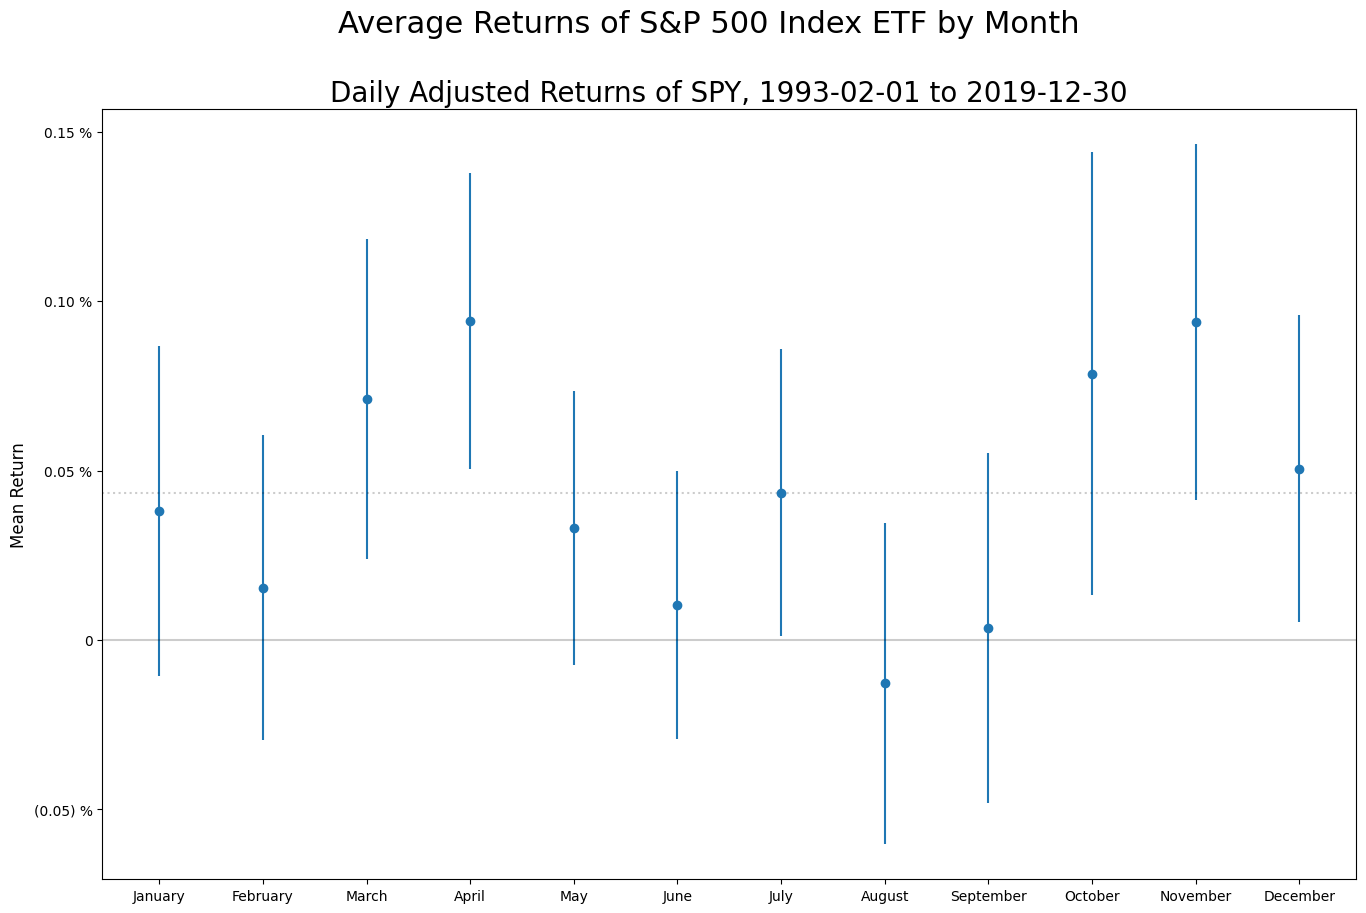

In [46]:
nprint("t Test for a Zero Mean")
results=(grouped:=data[['Return',group_name:='Month']].groupby(group_name)).mean().rename(columns={'Return':'Mean'})
results['Std.Dev.']=grouped.std()
results['Count']=grouped.count()
results['Std.Err.']=results['Std.Dev.']/np.sqrt(results['Count'])
results['t Statistic']=results['Mean']/results['Std.Err.']
results['p Value']=studentt.sf(np.abs(results['t Statistic']),results['Count']-1)*2
results.index.name=group_name
results=results.reindex(['January','February','March','April','May','June','July','August','September','October','November','December'])
display(results)

figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.errorbar(x:=results.index,y:=results['Mean'],ye:=results['Std.Err.'],fmt='o')
plot.axhline(color='black',alpha=0.2)
plot.set_ylabel("Mean Return",fontsize=12)
plot.yaxis.set_major_formatter(PercentLabels(2))
plot.axhline(data['Return'].mean(),color='black',alpha=0.2,linestyle=':')
figure.suptitle(title:="Average Returns of {} by {}".format(ticker_name,group_name),fontsize=22)
plot.set_title(subtitle:="Daily Adjusted Returns of {}, {} to {}".format(ticker,data.index[0],data.index[-1]),fontsize=20)
figure.savefig(filename:=title+'.png',dpi=300,bbox_inches='tight')
nprint("Wrote plot to {}.".format(filename))

nprint("One Way ANOVA Analysis by {}".format(group_name))
fit=OLSformula("Return ~ Weekday",data).fit()
anova=anova_lm(fit,typ=2).rename(columns={'sum_sq':'Sum of Squares','df':'d.o.f.','PR(>F)':'p Value','F':'F Statistic'})
anova['Significance']=anova['p Value'].apply(lambda x:'***' if x<=0.001 else '**' if x<=0.01 else '*' if x<0.05 else '')
anova.index=['Between Groups','Within Groups']
anova.index.name='Variation'
display(anova.replace(np.nan,""))

### Then the OLS with Indicator Variables

In [47]:
nprint("Baseline OLS regression with indicator variables. This should produce *exactly* the same results as the conditional means above.")
display(design:=pd.get_dummies(data['Month'],columns=['Month'],dtype=float)[results.index].merge(data['Return'],left_index=True,right_index=True))
fit=ols_fit=OLS(design['Return'],design.drop('Return',axis=1)).fit()
nprint(fit.summary())

15:53:37 Baseline OLS regression with indicator variables. This should produce *exactly* the same results as the conditional means above.


,January,February,March,April,May,June,July,August,September,October,November,December,Return
1993-02-01,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.711192
1993-02-02,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.211868
1993-02-03,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.057116
1993-02-04,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.418371
1993-02-05,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.069428
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.152781
2019-12-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.003104
2019-12-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.532318
2019-12-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.024781


15:53:37                             OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.5523
Date:                Tue, 22 Apr 2025   Prob (F-statistic):              0.868
Time:                        15:53:37   Log-Likelihood:                -10515.
No. Observations:                6778   AIC:                         2.105e+04
Df Residuals:                    6766   BIC:                         2.114e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
January        0.0380      0.050      0.767

### Finally fit the GJR-GARCH(1,1,1) Model

15:53:37 Fitting GJR-GARCH(1,1,1) Model with GED Innovations
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8759.478389065629
            Iterations: 27
            Function evaluations: 536
            Gradient evaluations: 27
15:53:38                               AR-X - GJR-GARCH Model Results                              
Dep. Variable:                             Return   R-squared:                       0.000
Mean Model:                                  AR-X   Adj. R-squared:                 -0.002
Vol Model:                              GJR-GARCH   Log-Likelihood:               -8759.48
Distribution:      Generalized Error Distribution   AIC:                           17553.0
Method:                        Maximum Likelihood   BIC:                           17668.9
                                                    No. Observations:                 6778
Date:                            Tue, Apr 22 2025   Df Residuals:                  

,Estimate,Std.Err.,Null Value,t Score,p Value
January,0.099406,0.026078,0.0,3.81191,0.000138
February,0.087654,0.032798,0.0,2.67256,0.007527
March,0.038449,0.030610,0.0,1.25609,0.209083
April,0.070573,0.027603,0.0,2.556696,0.010567
May,0.035024,0.020313,0.0,1.724204,0.084671
June,0.029687,0.031075,0.0,0.95534,0.339406
July,0.043957,0.023970,0.0,1.83385,0.066676
August,0.028931,0.024892,0.0,1.162293,0.245116
September,0.022705,0.027764,0.0,0.817791,0.413477
October,0.074697,0.027809,0.0,2.686055,0.00723


15:53:39 Wrote plot to Effect of Volatility on Estimated Returns of S&P 500 Index ETF by Month.png.


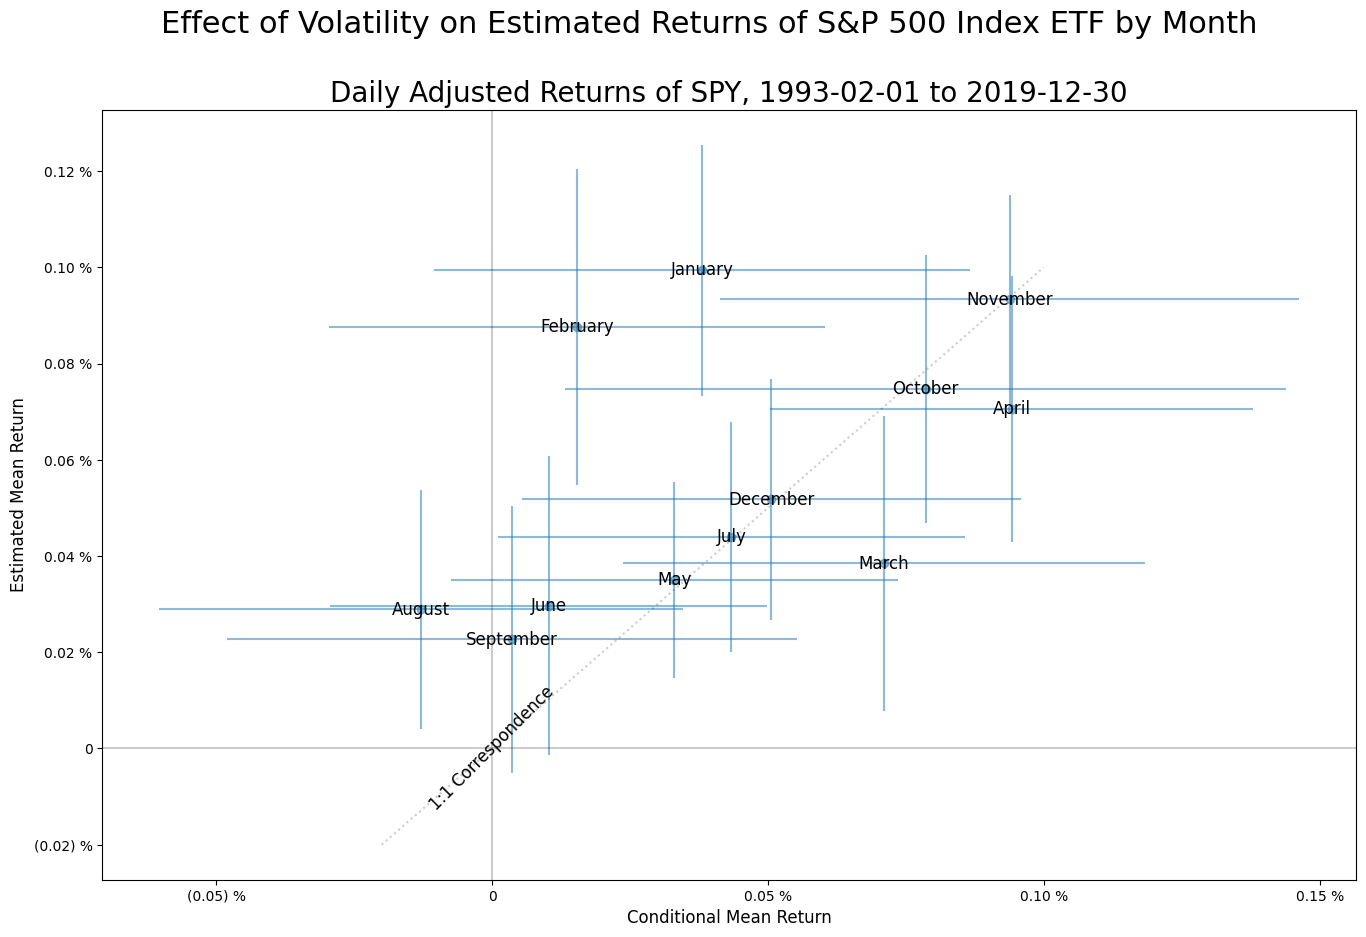

In [48]:
nprint("Fitting GJR-GARCH(1,1,1) Model with GED Innovations")
model=ARX(design["Return"],design.drop('Return',axis=1),constant=False,lags=0)
model.volatility=GARCH2(1,1,1)
model.distribution=GeneralizedError2()
fit=gjr_fit=model.fit(update_freq=0)
nprint(gjr_fit.summary())
data['Volatility']=gjr_fit.conditional_volatility

results=pd.DataFrame({'Estimate':fit.params,'Std.Err.':fit.std_err,'Null Value':[zero]*(len(fit.params)-5)+[np.nan]*4+[two]})
results['t Score']=(results['Estimate']-results['Null Value'])/results['Std.Err.']
results['p Value']=list(map(lambda x:min(norm.cdf(x),norm.sf(x))*two,results['t Score']))
display(results.replace(np.nan,""))

figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.errorbar(xx:=y,yy:=results.loc[x,'Estimate'],xerr=ye,yerr=results.loc[x,'Std.Err.'],fmt='o',alpha=0.5)

for day in x:
  plot.text(xx.loc[day],yy.loc[day],day,ha='center',va='center',fontsize=12)

plot.plot(r:=[min([-0.02,xx.min(),yy.min()]),max([0.1,xx.max(),yy.max()])],r,':',color='black',alpha=0.2)
plot.text(zero,zero,'1:1 Correspondence',fontsize=12,ha='center',va='center',rotation=45)
plot.axhline(color='black',alpha=0.2)
plot.axvline(color='black',alpha=0.2)
plot.set_xlabel("Conditional Mean Return",fontsize=12)
plot.set_ylabel("Estimated Mean Return",fontsize=12)
plot.xaxis.set_major_formatter(PercentLabels(2))
plot.yaxis.set_major_formatter(PercentLabels(2))
figure.suptitle(title:="Effect of Volatility on Estimated Returns of {} by {}".format(ticker_name,group_name),fontsize=22)
plot.set_title(subtitle:="Daily Adjusted Returns of {}, {} to {}".format(ticker,data.index[0],data.index[-1]),fontsize=20)
figure.savefig(filename:=title+'.png',dpi=300,bbox_inches='tight')
nprint("Wrote plot to {}.".format(filename))

### Repeat the Simple Plot by Month

15:53:40 Wrote plot to Estimated Mean Returns of S&P 500 Index ETF by Month.png.


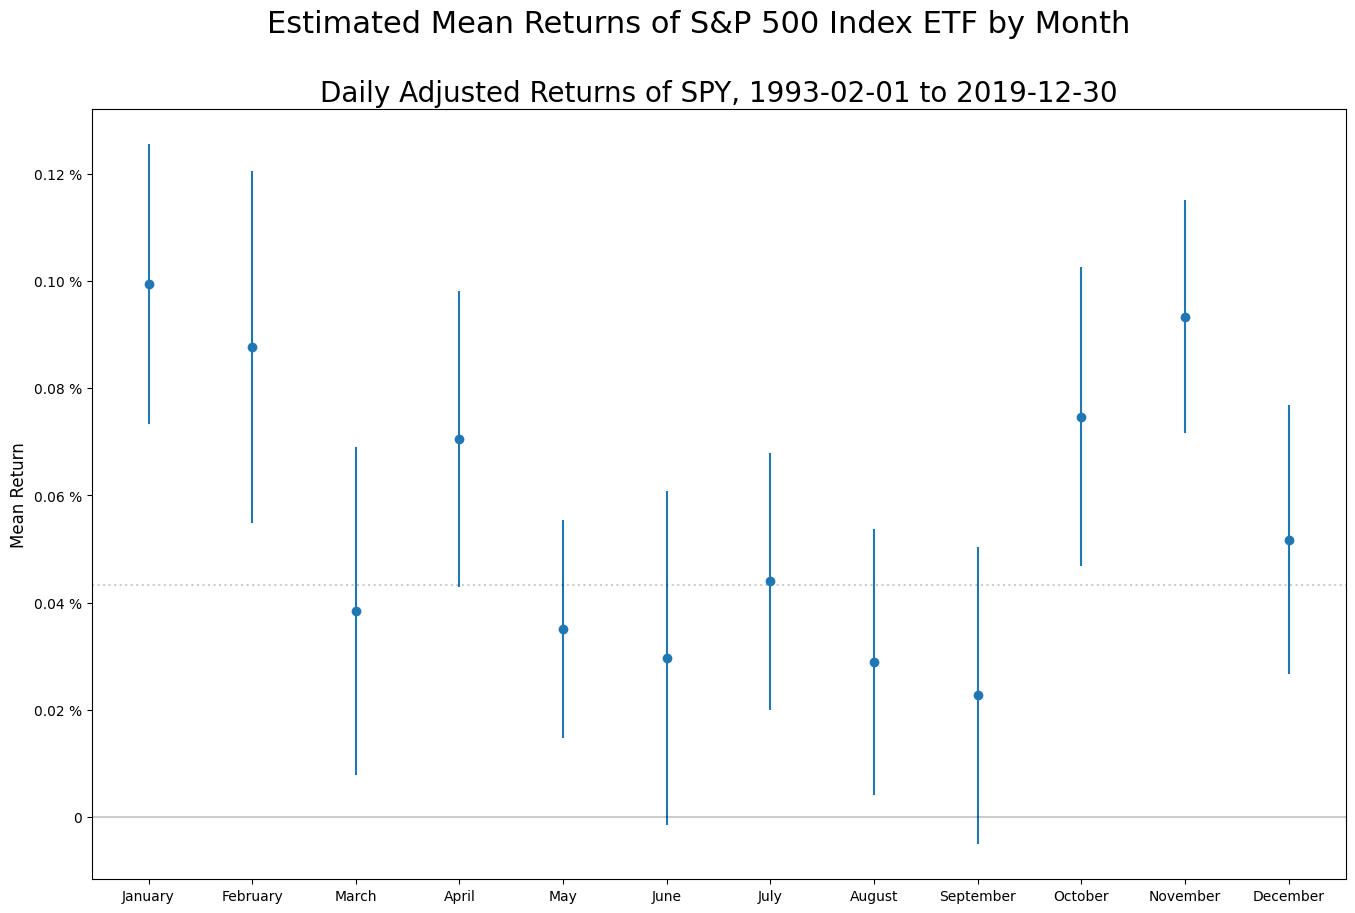

In [49]:
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.errorbar(x,results.loc[x,'Estimate'],results.loc[x,'Std.Err.'],fmt='o')
plot.axhline(color='black',alpha=0.2)
plot.set_ylabel("Mean Return",fontsize=12)
plot.yaxis.set_major_formatter(PercentLabels(2))
plot.axhline(data['Return'].mean(),color='black',alpha=0.2,linestyle=':')
figure.suptitle(title:="Estimated Mean Returns of {} by {}".format(ticker_name,group_name),fontsize=22)
plot.set_title(subtitle:="Daily Adjusted Returns of {}, {} to {}".format(ticker,data.index[0],data.index[-1]),fontsize=20)
figure.savefig(filename:=title+'.png',dpi=300,bbox_inches='tight')
nprint("Wrote plot to {}.".format(filename))